# Metrics and Results Comparison

## Efficiency vs. Complexity: Model Evaluation

This analysis compares a parameter-efficient architecture (LeNet-5) against a high-capacity Custom CNN. 

The goal is to evaluate how model complexity impacts classification performance on the Fashion-MNIST dataset. 

These two structures are used to analyze if a significant increase in parameter density actually provides a measurable advantage for low-resolution image data.

### Loading optimal models

In [1]:
# Neccessary imports
import torch
import torch.nn as nn
import pandas as pd
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
print("Loading models...")

# LeNet5 Architecture
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
    
    def forward(self, x):
        out = torch.tanh(self.conv1(x))
        out = self.avgpool1(out)
        out = torch.tanh(self.conv2(out))
        out = self.avgpool2(out)
        out = out.reshape(out.size(0), -1)
        out = torch.tanh(self.fc1(out))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Custom CNN Architecture
class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1600, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 10

# Load LeNet-5
lenet_model = LeNet5(num_classes).to(device)
lenet_model.load_state_dict(torch.load('best_lenet5_model.pth', map_location=device))
lenet_model.eval()

# Load Custom CNN
custom_cnn_model = ConvNeuralNet(num_classes).to(device)
custom_cnn_model.load_state_dict(torch.load('best_cnn_model.pth', map_location=device))
custom_cnn_model.eval()

print("Done!")

Loading models...
Done!


### Loading data

In [3]:
print("Loading data...")

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the Fashion-MNIST test dataset
test_dataset = datasets.FashionMNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# Define the test loader
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=100, 
    shuffle=False
)

# Define class names for the Confusion Matrix
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"Loaded {len(test_dataset)} images.")

Loading data...
Loaded 10000 images.


## Architectural Comparison

The two models represent different approaches to feature extraction. 

The LetNet5 model uses a shallow structure with limited filters, while the Custom model utilizes a deeper stack of layers and modern optimizations like ReLU and Max Pooling to capture finer textures.

The custom model is created to try achieving better performance by making the model more complex.

In [4]:
# Table comparison of the models
comparison_data = {
    "Feature": [
        "Depth", 
        "Feature Maps", 
        "Activation", 
        "Pooling", 
        "Total Parameters"
    ],
    "LeNet-5 (1998)": [
        "2 Conv Layers", 
        "Low (6 → 16)", 
        "Tanh (Slower, vanishing gradients)", 
        "Average Pooling (Smooths features)", 
        "~61,706"
    ],
    "Custom CNN (Modern)": [
        "4 Conv Layers", 
        "High (32 → 64)", 
        "ReLU (Faster, avoids gradient death)", 
        "Max Pooling (Detects sharp edges)", 
        "~1,000,000+"
    ]
}

df_comparison = pd.DataFrame(comparison_data)
df_comparison.set_index("Feature", inplace=True)

display(df_comparison)

,LeNet-5 (1998),Custom CNN (Modern)
Feature,,
Depth,2 Conv Layers,4 Conv Layers
Feature Maps,Low (6 → 16),High (32 → 64)
Activation,"Tanh (Slower, vanishing gradients)","ReLU (Faster, avoids gradient death)"
Pooling,Average Pooling (Smooths features),Max Pooling (Detects sharp edges)
Total Parameters,"~61,706","~1,000,000+"


## Primary Performance Metrics

To accurately assess how model complexity impacts performance both architectures are evaluated using standard metrics.

In [5]:
# Imports
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np

### Accuracy

The primary metric for evaluating model performance is accuracy, defined as the ratio of correctly predicted instances to the total number of images in the test set.

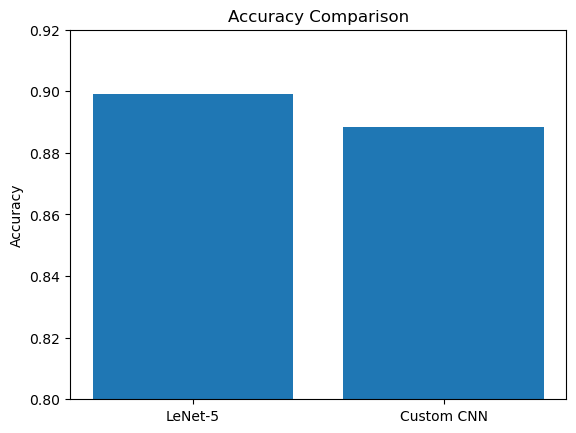

LeNet-5: 0.8991 | Custom CNN: 0.8885


In [6]:
# Calculate accuracy
def get_acc(model):
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images.to(device))
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())
    return accuracy_score(all_labels, all_preds)

acc_lenet = get_acc(lenet_model)
acc_custom = get_acc(custom_cnn_model)

# Plot
plt.bar(["LeNet-5", "Custom CNN"], [acc_lenet, acc_custom])
plt.ylim(0.8, 0.92)
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.show()

print(f"LeNet-5: {acc_lenet:.4f} | Custom CNN: {acc_custom:.4f}")

### Precision

Precision focuses on the accuracy of positive predictions. 

It measures how many of the items assigned to a specific category actually belonged there.

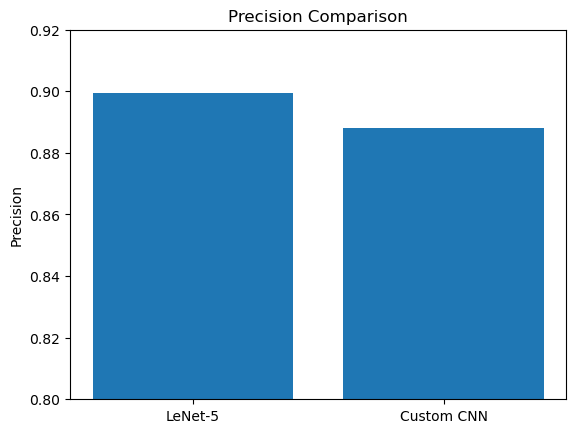

LeNet-5 Precision: 0.8996 | Custom CNN Precision: 0.8882


In [7]:
# Calculate precision
def get_precision(model):
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images.to(device))
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())
    return precision_score(all_labels, all_preds, average='macro')

prec_lenet = get_precision(lenet_model)
prec_custom = get_precision(custom_cnn_model)

# Plot
plt.bar(["LeNet-5", "Custom CNN"], [prec_lenet, prec_custom])
plt.ylim(0.8, 0.92)
plt.ylabel('Precision')
plt.title('Precision Comparison')
plt.show()

print(f"LeNet-5 Precision: {prec_lenet:.4f} | Custom CNN Precision: {prec_custom:.4f}")

### Recall

Recall measures the model's ability to find all the actual members of a category.

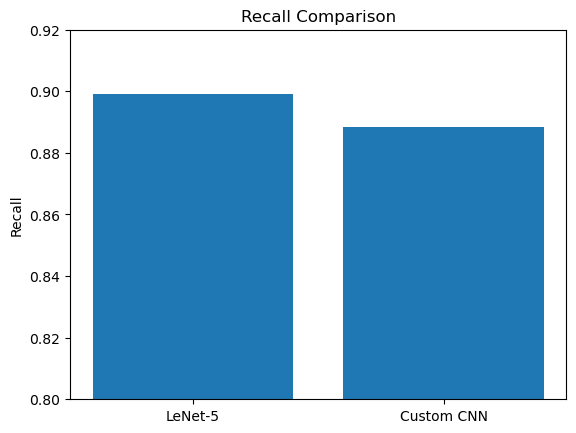

LeNet-5 Recall: 0.8991 | Custom CNN Recall: 0.8885


In [8]:
# Calculate recall
def get_recall(model):
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images.to(device))
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())
    return recall_score(all_labels, all_preds, average='macro')

rec_lenet = get_recall(lenet_model)
rec_custom = get_recall(custom_cnn_model)

# Plot
plt.bar(["LeNet-5", "Custom CNN"], [rec_lenet, rec_custom])
plt.ylim(0.8, 0.92)
plt.ylabel('Recall')
plt.title('Recall Comparison')
plt.show()

print(f"LeNet-5 Recall: {rec_lenet:.4f} | Custom CNN Recall: {rec_custom:.4f}")

### F1

The F1-Score is the harmonic mean of Precision and Recall. 

If a model has a high F1-Score, it means it is both accurate in its guesses (Precision) and thorough in finding items (Recall).

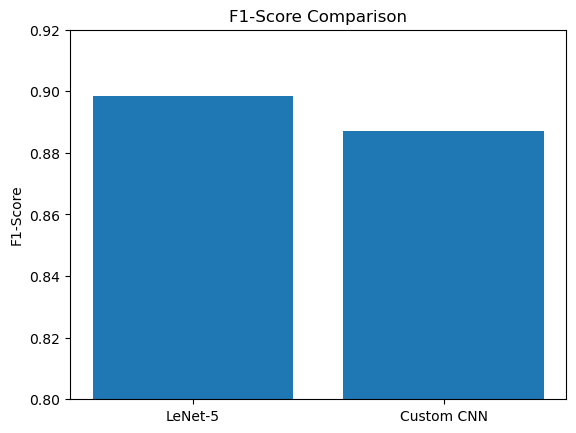

LeNet-5 F1-Score: 0.8985 | Custom CNN F1-Score: 0.8872


In [9]:
# Calculate F1
def get_f1(model):
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images.to(device))
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())
    return f1_score(all_labels, all_preds, average='macro')

f1_lenet = get_f1(lenet_model)
f1_custom = get_f1(custom_cnn_model)

# Plot
plt.bar(["LeNet-5", "Custom CNN"], [f1_lenet, f1_custom])
plt.ylim(0.8, 0.92)
plt.ylabel('F1-Score')
plt.title('F1-Score Comparison')
plt.show()

print(f"LeNet-5 F1-Score: {f1_lenet:.4f} | Custom CNN F1-Score: {f1_custom:.4f}")

#### Conclusion

Both the LeNet-5 and the Custom CNN demonstrate strong performance across all primary metrics, with each achieving approximately 89-90% in Accuracy, Precision, Recall, and F1-Score. 

These high, balanced scores indicate that both architectures are well-suited for fashion classification.

## Confusion Matrix

The confusion matrix identifies specific classification errors by showing which fashion items are most frequently mistaken for others. 

While categories like "Trouser" are usually distinct, visually similar items like "Shirt," "T-shirt," and "Coat" often account for the majority of misclassifications. 

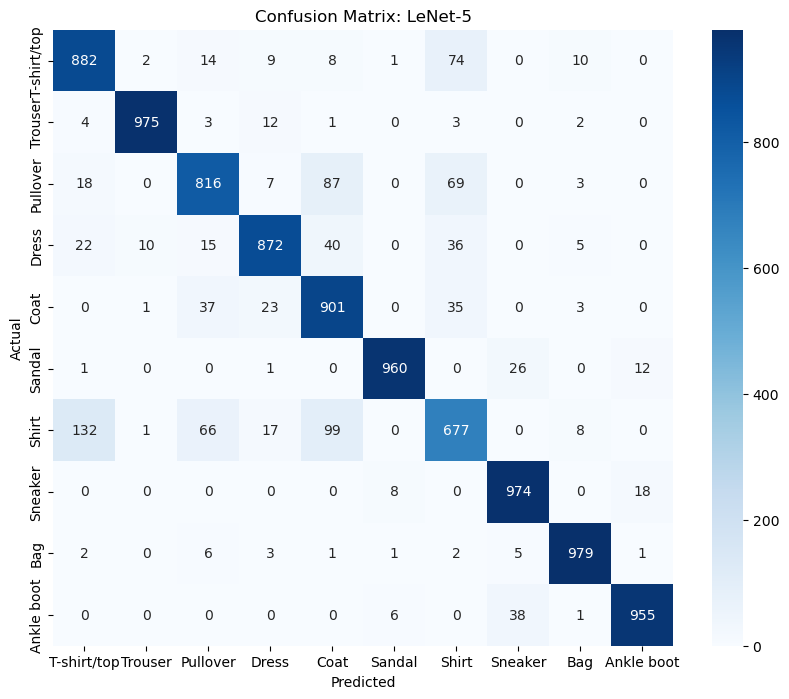

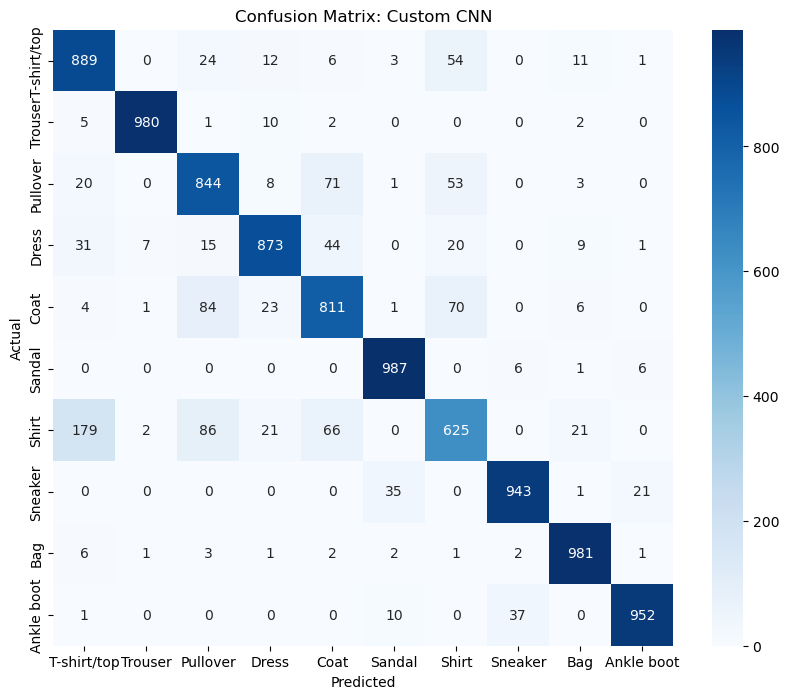

In [10]:
# Helper function for plotting confusion matrices
def plot_cm(model, loader, title):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())
            
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix: {title}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Display for both models
plot_cm(lenet_model, test_loader, "LeNet-5")
plot_cm(custom_cnn_model, test_loader, "Custom CNN")

#### Conclusion

Both models exhibit nearly identical confusion patterns, frequently misclassifying Shirts, Coats, and T-shirts. 

These shared errors suggest that the visual similarity of the clothing items is the cause of misclassification and not model complexity. 

The high-capacity Custom CNN offers no distinct advantage in resolving these specific category overlaps.

## ROC Curve

The ROC curve and AUC (Area Under the Curve) measure how effectively the model separates each fashion category at different levels of confidence.

The ROC curve visualizes the specific trade-off between identifying correct items (True Positives) and avoiding false labels (False Positives). 

The AUC summarizes this performance into a value between 0 and 1, where a higher score indicates the model is better at distinguishing between visually similar items, such as Shirts and Coats.

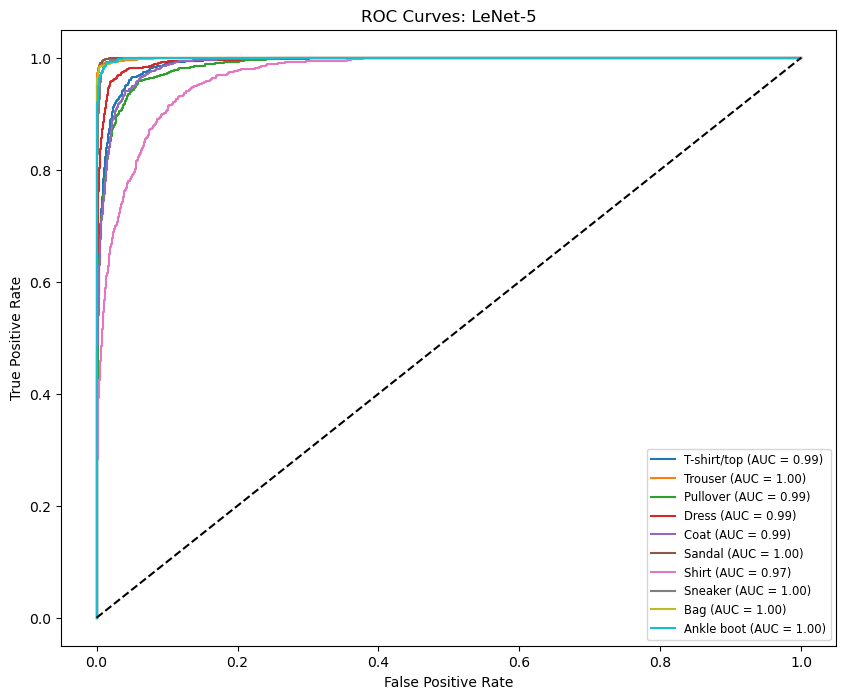

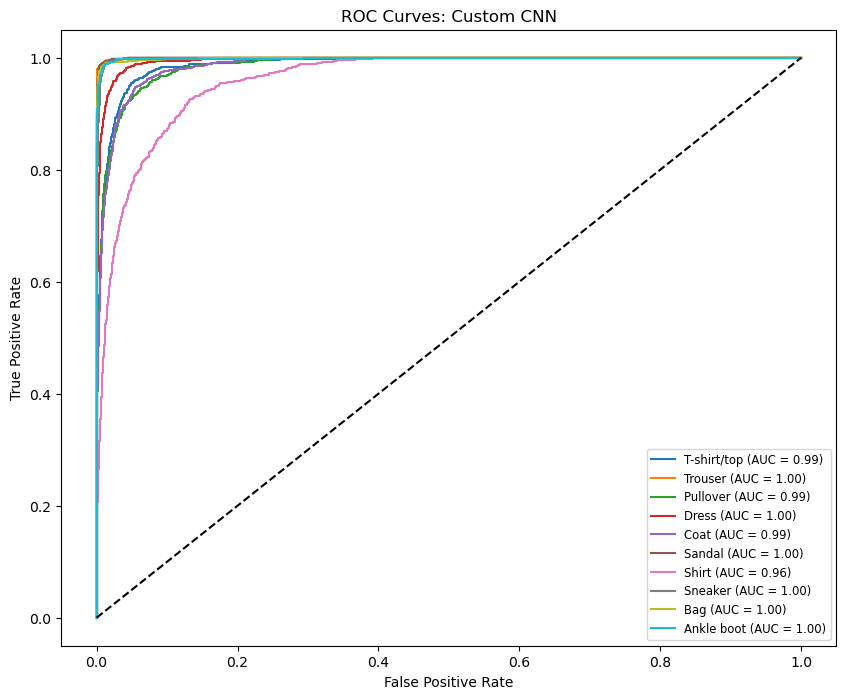

In [11]:
def plot_roc(model, loader, title):
    model.eval()
    y_true, y_probs = [], []
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images.to(device))
            y_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
            y_true.extend(labels.numpy())
    
    y_true_bin = label_binarize(y_true, classes=range(10))
    y_probs = np.array(y_probs)
    
    plt.figure(figsize=(10, 8))
    for i in range(10):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc(fpr, tpr):.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves: {title}')
    plt.legend(loc='lower right', fontsize='small')
    plt.show()

plot_roc(lenet_model, test_loader, "LeNet-5")
plot_roc(custom_cnn_model, test_loader, "Custom CNN")

## Final conclusion: Efficiency vs. Complexity

The comparison between LeNet-5 and the Custom CNN on the Fashion-MNIST dataset provides an insight into the relationship between model complexity and performance on low-resolution images.

### Results

LeNet-5 proved to be highly effective, achieving accuracy of 89.9% using about 61,000 parameters. This demonstrates that classic, simpler architectures are still highly capable of handling low-resolution image tasks with great precision.

On the other hand, the Custom CNN reached a very similar performance level of 88.8%, but it utilized over 1,000,000 parameters to get there. 

These results suggest that for 28×28 grayscale images, the extra complexity isn't strictly necessary to achieve good results. 

Both models reached a similar finish line, but LeNet-5 did so with much higher efficiency.

Both models encountered the same problematic parts in their respective Confusion Matrices, particularly when trying to distinguish between Shirts, Coats, and T-shirts. 

Because both the simple and complex models struggled with these specific categories, it indicates that the errors are likely due to the natural visual similarity of the clothing items themselves rather than a weakness in either model's design. 

This analysis proves that a well-matched, smaller model can be just as powerful as a much larger one for this type of data.